# Projeto: Saúde no Trabalho & Natureza — Notebook (14 dias)

Notebook gerado automaticamente. Simula 14 dias de leituras (5-min) e treina dois modelos:
- Regressão (prever kWh futuros / consumo)
- Classificação (rotular ambiente como 'saudavel','moderado','nao_saudavel').



In [15]:
!pip install -q tensorflow pandas scikit-learn matplotlib
!pip install ultralytics
!pip install opencv-python
!pip install pillow

print('Dependências instaladas')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.2 MB/s eta 0:00:00
Dependências instaladas


In [3]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime

json_path = '/content/dados_iot_14dias.json'
with open(json_path,'r') as f:
    data = json.load(f)

print('Sensor:', data.get('sensor_id'))
print('Localização:', data.get('localizacao'))
df = pd.DataFrame(data['leituras'])
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)
print('Registros:', len(df))
df.head()

Sensor: dht22_01
Localização: Ambiente de Trabalho
Registros: 4032


,timestamp,temperatura,umidade,co2,luminosidade,ruido,uso_notebook_W,uso_monitor_W,power_w,consumo_kwh_interval,tempo_uso_min
0,2025-10-30 22:25:45,21.59,48.75,407.2,30,41,6.98,5.68,16.83,0.001402,0
1,2025-10-30 22:30:45,20.77,59.00,393.6,36,41,8.10,9.20,21.40,0.001784,0
2,2025-10-30 22:35:45,22.85,56.13,399.3,45,44,9.83,9.85,22.53,0.001878,0
3,2025-10-30 22:40:45,20.96,57.32,466.6,26,42,5.49,6.61,15.69,0.001308,0
4,2025-10-30 22:45:45,23.19,58.86,424.0,49,40,5.26,7.24,17.46,0.001455,0


In [4]:
# Criar label de classificação baseada em regras simples
# saudavel: temperatura 20-26, umidade 30-60, co2<800, ruido<65, luminosidade>200
# moderado: se 1 ou 2 métricas fora
# nao_saudavel: 3+ métricas fora

def label_row(row):
    issues = 0
    if not (20 <= row['temperatura'] <= 26): issues += 1
    if not (30 <= row['umidade'] <= 60): issues += 1
    if not (row['co2'] < 800): issues += 1
    if not (row['ruido'] < 65): issues += 1
    if not (row['luminosidade'] > 100): issues += 1
    if issues == 0:
        return 'saudavel'
    elif issues <= 2:
        return 'moderado'
    else:
        return 'nao_saudavel'


df['label'] = df.apply(label_row, axis=1)
df['consumo_kwh_cumsum_24h'] = df['consumo_kwh_interval'].rolling(window=12*24, min_periods=1).sum()

df[['timestamp','temperatura','umidade','co2','ruido','luminosidade','label']].head()

,timestamp,temperatura,umidade,co2,ruido,luminosidade,label
0,2025-10-30 22:25:45,21.59,48.75,407.2,41,30,moderado
1,2025-10-30 22:30:45,20.77,59.00,393.6,41,36,moderado
2,2025-10-30 22:35:45,22.85,56.13,399.3,44,45,moderado
3,2025-10-30 22:40:45,20.96,57.32,466.6,42,26,moderado
4,2025-10-30 22:45:45,23.19,58.86,424.0,40,49,moderado


In [5]:
# Preparar dados para regressão (prever consumo nas próximas 12 janelas = 1 hora)
# Usaremos janelas de 12 intervals (última hora) para prever kWh nos próximos 12 intervals (soma futura 1h)
window_in = 12
window_out = 12

df['consumo_kwh_future_1h'] = df['consumo_kwh_interval'].rolling(window=window_out, min_periods=1).sum().shift(-window_out+1)
# feature columns
features = ['temperatura','umidade','co2','luminosidade','ruido','uso_notebook_W','uso_monitor_W','power_w']

# build sequences
X_reg = []
y_reg = []
for i in range(len(df)-window_in-window_out+1):
    X_reg.append(df[features].iloc[i:i+window_in].values.flatten())
    y_reg.append(df['consumo_kwh_future_1h'].iloc[i+window_in-1])
X_reg = np.array(X_reg)
y_reg = np.array(y_reg)

print('X_reg shape', X_reg.shape, 'y_reg shape', y_reg.shape)

# split
split = int(0.8*len(X_reg))
Xr_train, Xr_test = X_reg[:split], X_reg[split:]
yr_train, yr_test = y_reg[:split], y_reg[split:]

# normalizar
mean = Xr_train.mean(axis=0)
std = Xr_train.std(axis=0) + 1e-8
Xr_train_s = (Xr_train-mean)/std
Xr_test_s = (Xr_test-mean)/std

print('Dados prontos para regressão')

X_reg shape (4009, 96) y_reg shape (4009,)
Dados prontos para regressão


In [6]:
# Treinar modelo Keras para regressão (previsão de consumo 1h)
from tensorflow.keras import layers, models

model_reg = models.Sequential([
    layers.Input(shape=(Xr_train_s.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])
model_reg.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_reg = model_reg.fit(Xr_train_s, yr_train, epochs=30, batch_size=64, validation_data=(Xr_test_s, yr_test), verbose=0)
loss_r, mae_r = model_reg.evaluate(Xr_test_s, yr_test, verbose=0)
print('Regressão - MAE:', mae_r)


Regressão - MAE: 0.044630613178014755


In [7]:
# Preparar dados para classificação (one-hot encode labels)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])

# use single-row features (no sequence) for classification
X_clf = df[features].values
y_clf = df['label_enc'].values

split2 = int(0.8*len(X_clf))
Xc_train, Xc_test = X_clf[:split2], X_clf[split2:]
yc_train, yc_test = y_clf[:split2], y_clf[split2:]

# normalize
mean_c = Xc_train.mean(axis=0)
std_c = Xc_train.std(axis=0) + 1e-8
Xc_train_s = (Xc_train-mean_c)/std_c
Xc_test_s = (Xc_test-mean_c)/std_c

print('Dados prontos para classificação. Classes:', list(le.classes_))

Dados prontos para classificação. Classes: ['moderado', 'saudavel']


In [8]:
# Treinar modelo Keras para classificação
from tensorflow.keras.utils import to_categorical

yc_train_cat = to_categorical(yc_train)
yc_test_cat = to_categorical(yc_test)

model_clf = models.Sequential([
    layers.Input(shape=(Xc_train_s.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(yc_train_cat.shape[1], activation='softmax')
])
model_clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_clf = model_clf.fit(Xc_train_s, yc_train_cat, epochs=25, batch_size=128, validation_data=(Xc_test_s, yc_test_cat), verbose=0)
loss_c, acc_c = model_clf.evaluate(Xc_test_s, yc_test_cat, verbose=0)
print('Classificação - Accuracy:', acc_c)


Classificação - Accuracy: 0.983890950679779


In [9]:
import numpy as np
from datetime import datetime

# 1) Regressão: prever consumo 1h para a última janela
last_in = df[features].iloc[-window_in:].values.flatten().reshape(1,-1)
last_in_s = (last_in - mean) / std
pred_kwh_next_1h = float(model_reg.predict(last_in_s)[0,0])

resultado_reg = {
    'timestamp': datetime.now().isoformat(),
    'pred_kwh_next_1h': pred_kwh_next_1h,
    'mae_test': float(mae_r)
}

# 2) Classificação: classificar último registro
last_row = df[features].iloc[-1].values.reshape(1,-1)
last_row_s = (last_row - mean_c) / std_c
pred_proba_arr = model_clf.predict(last_row_s)[0]            # numpy array
pred_proba = [float(x) for x in pred_proba_arr.tolist()]     # lista de floats
pred_idx = int(np.argmax(pred_proba_arr))                    # índice da classe com maior probabilidade
pred_label = le.inverse_transform([pred_idx])[0]

# obter a última leitura e tornar tudo serializável
ultima_raw = df[['timestamp','temperatura','umidade','co2','ruido','luminosidade']].iloc[-1].to_dict()

def make_json_serializable(obj):
    # pandas Timestamp -> isoformat string
    if hasattr(obj, 'isoformat'):
        return obj.isoformat()
    # numpy scalar -> python native
    if isinstance(obj, (np.integer,)):
        return int(obj)
    if isinstance(obj, (np.floating,)):
        return float(obj)
    return obj

ultima_clean = {k: make_json_serializable(v) for k,v in ultima_raw.items()}

resultado_clf = {
    'timestamp': datetime.now().isoformat(),
    'ultima_leitura': ultima_clean,
    'pred_probabilidades': {le.classes_[i]: pred_proba[i] for i in range(len(pred_proba))},
    'pred_label': pred_label,
    'accuracy_test': float(acc_c)
}

# caminhos de saída (ajuste se quiser outro diretório)
out_reg = '/content/resultado_previsao_energia.json'
out_clf = '/content/resultado_classificacao.json'

# salvar JSONs
with open(out_reg, 'w', encoding='utf-8') as f:
    json.dump(resultado_reg, f, indent=2, ensure_ascii=False)

with open(out_clf, 'w', encoding='utf-8') as f:
    json.dump(resultado_clf, f, indent=2, ensure_ascii=False)

print('Arquivos salvos:', out_reg, out_clf)
resultado_reg, resultado_clf


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Arquivos salvos: /content/resultado_previsao_energia.json /content/resultado_classificacao.json


({'timestamp': '2025-11-17T21:28:32.158633',
  'pred_kwh_next_1h': 0.00815653707832098,
  'mae_test': 0.044630613178014755},
 {'timestamp': '2025-11-17T21:28:32.412427',
  'ultima_leitura': {'timestamp': '2025-11-13T22:20:45',
   'temperatura': 23.36,
   'umidade': 54.47,
   'co2': 401.2,
   'ruido': 41,
   'luminosidade': 33},
  'pred_probabilidades': {'moderado': 0.9999648332595825,
   'saudavel': 3.518581797834486e-05},
  'pred_label': 'moderado',
  'accuracy_test': 0.983890950679779})

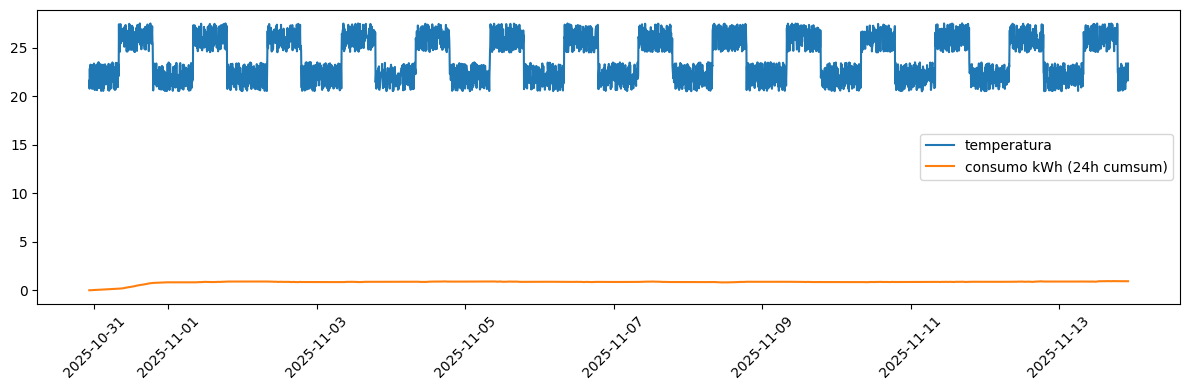

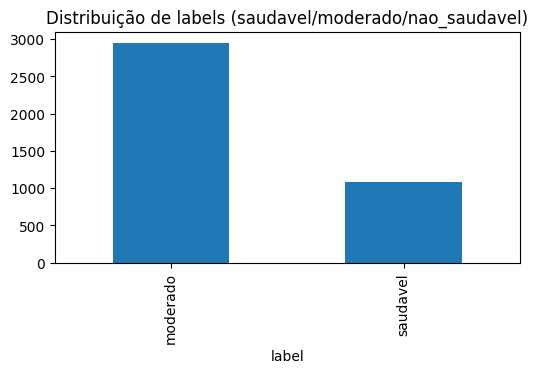

In [10]:
# Visualizações rápidas
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(df['timestamp'], df['temperatura'], label='temperatura')
plt.plot(df['timestamp'], df['consumo_kwh_cumsum_24h'], label='consumo kWh (24h cumsum)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mostrar distribuição de labels
plt.figure(figsize=(6,3))
df['label'].value_counts().plot(kind='bar')
plt.title('Distribuição de labels (saudavel/moderado/nao_saudavel)')
plt.show()

In [11]:
# Disponibilizar downloads (Colab)
from google.colab import files
files.download('/content/resultado_previsao_energia.json')
files.download('/content/resultado_classificacao.json')
files.download('/content/dados_iot_14dias.json')

print('Se estiver em ambiente não-Colab, os arquivos estão em /mnt/data')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Se estiver em ambiente não-Colab, os arquivos estão em /mnt/data


In [17]:
# ====================================================
#       MÓDULO DE VISÃO COMPUTACIONAL (YOLOv8)
#        Análise da saúde do ambiente de trabalho
# ====================================================


from ultralytics import YOLO
from google.colab import files
import json
from datetime import datetime

# -------------------------------------------
# 1) Carregar modelo YOLO pré-treinado
# -------------------------------------------
model_yolo = YOLO('yolov8n.pt')  # modelo leve e rápido

print("Modelo YOLO carregado.")

# -------------------------------------------
# 2) Upload da imagem para análise
# -------------------------------------------
uploaded = files.upload()

img_path = list(uploaded.keys())[0]
print("Imagem carregada:", img_path)

# -------------------------------------------
# 3) Rodar detecção
# -------------------------------------------
results = model_yolo(img_path)[0]

objetos_detectados = []
for box in results.boxes:
    cls_id = int(box.cls)
    conf = float(box.conf)
    classe = results.names[cls_id]
    objetos_detectados.append({
        "classe": classe,
        "conf": round(conf, 4)
    })

# -------------------------------------------
# 4) Criar lógicas de saúde / natureza
# -------------------------------------------

# ergonomia básica (detecção de "pessoa" + "chair" = postura aceitável)
tem_pessoa = any(obj["classe"] == "person" for obj in objetos_detectados)
tem_cadeira = any(obj["classe"] == "chair" for obj in objetos_detectados)

postura_saudavel = tem_pessoa and tem_cadeira

# indicadores de natureza (plantas detectadas)
plantas = [obj for obj in objetos_detectados if obj["classe"] in ["potted plant", "plant"]]
plantas_detectadas = len(plantas)

eco_score = min(1.0, 0.2 + 0.2 * plantas_detectadas)

# -------------------------------------------
# 5) Salvar JSON final do YOLO
# -------------------------------------------

resultado_yolo = {
    "timestamp": datetime.now().isoformat(),
    "imagem_analisada": img_path,
    "objetos_detectados": objetos_detectados,
    "postura_saudavel": postura_saudavel,
    "indicadores_natureza": {
        "plantas_detectadas": plantas_detectadas,
        "eco_score": eco_score
    }
}

out_yolo = "/content/resultado_yolo.json"

with open(out_yolo, "w", encoding="utf-8") as f:
    json.dump(resultado_yolo, f, indent=2, ensure_ascii=False)

print("JSON YOLO salvo em:", out_yolo)
print(resultado_yolo)


Modelo YOLO carregado.


Saving ambiente de trabalho.jpg to ambiente de trabalho (1).jpg
Imagem carregada: ambiente de trabalho (1).jpg

image 1/1 /content/ambiente de trabalho (1).jpg: 448x640 7 persons, 1 cup, 1 potted plant, 1 dining table, 1 tv, 2 laptops, 1 keyboard, 1 cell phone, 1 book, 176.8ms
Speed: 3.7ms preprocess, 176.8ms inference, 5.2ms postprocess per image at shape (1, 3, 448, 640)
JSON YOLO salvo em: /content/resultado_yolo.json
{'timestamp': '2025-11-17T21:50:25.506896', 'imagem_analisada': 'ambiente de trabalho (1).jpg', 'objetos_detectados': [{'classe': 'laptop', 'conf': 0.9094}, {'classe': 'person', 'conf': 0.8902}, {'classe': 'person', 'conf': 0.8318}, {'classe': 'person', 'conf': 0.8225}, {'classe': 'person', 'conf': 0.8217}, {'classe': 'person', 'conf': 0.7582}, {'classe': 'cup', 'conf': 0.6892}, {'classe': 'person', 'conf': 0.658}, {'classe': 'cell phone', 'conf': 0.5604}, {'classe': 'tv', 'conf': 0.4499}, {'classe': 'person', 'conf': 0.3353}, {'classe': 'potted plant', 'conf': 0.3197}